In [10]:
from data_loader import create_datasets, prepare_datasets

import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from keras.applications import VGG16 
import os
import numpy as np
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [2]:
# Load the  xfered/augmented model
model2 = keras.models.load_model('../../skin_cancer_model_transfer.keras')

# Load base model
model = keras.models.load_model('../../skin_cancer_model_baseline.keras')

In [6]:
# bring in dataset

test_dir = '../../Skin_Data/Test'
test = create_datasets(test_dir)

Found 204 files belonging to 2 classes.
Using 164 files for training.
Using 40 files for validation.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [11]:
import tensorflow as tf

def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2] == 'Cancer'
    label = tf.cast(label, tf.int32)  # Convert to binary label
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [180, 180])  # Resize the image to match model's expected input
    img = img / 255.0  # Normalize the image
    return img, label

# Set the path to your test directory
test_dir = '../../Skin_Data/Test'

# List dataset of file paths
list_ds = tf.data.Dataset.list_files(f"{test_dir}/*/*", shuffle=False)
test_dataset = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the data
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [13]:
# Predict with both models
preds1 = model.predict(test_dataset)
preds2 = model2.predict(test_dataset)


2024-05-01 06:49:56.094065: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132710400 exceeds 10% of free system memory.
2024-05-01 06:49:56.539750: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132710400 exceeds 10% of free system memory.
2024-05-01 06:49:57.000985: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132710400 exceeds 10% of free system memory.
2024-05-01 06:49:57.384516: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 265420800 exceeds 10% of free system memory.
2024-05-01 06:49:58.185395: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 265420800 exceeds 10% of free system memory.


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


In [14]:
# Collect all labels
true_labels = np.concatenate([y.numpy() for _, y in test_dataset])


2024-05-01 06:54:34.895729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


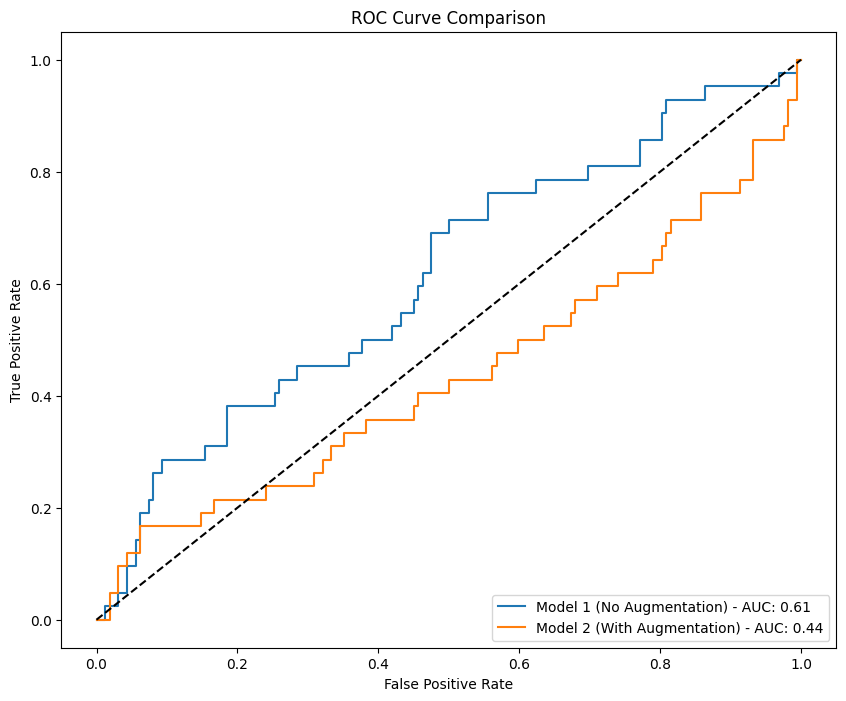

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC metrics
fpr1, tpr1, _ = roc_curve(true_labels, preds1)
fpr2, tpr2, _ = roc_curve(true_labels, preds2)

# Calculate AUC
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label=f'Model 1 (No Augmentation) - AUC: {auc1:.2f}')
plt.plot(fpr2, tpr2, label=f'Model 2 (With Augmentation) - AUC: {auc2:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


Something has gone wrong here. It's possible the results are swapped.